# Anime recommendation content-based

We use a dataset 

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from warnings import filterwarnings
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)

In [5]:
df = pd.read_csv('../data/anime-recommendations-database/anime.csv')
df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


# Data visualization

In [6]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def clean_string(x):
    try:
        return str(x)
    except:
        return np.nan
    
def remove_data(data):
    df_data = data.copy()
    odd = ['Mecha', 'Yuri', 'Ecchi', 'Josei', 'Harem', 'Dementia', 'Shounen Ai', 'Hentai', 'Yaoi', 'Shoujo', 'Shoujo Ai', 'nan']
    df_data['genre'] = df_data['genre'].apply(lambda x: 'Odd' if list(set(str(x).split(', ')) & set(odd)) != [] else x)
    df_data = df_data[~df_data['genre'].str.contains('Odd')] # Keep cells that have no 'Odd label'. There are 44 remaining different genres
    
    return df_data

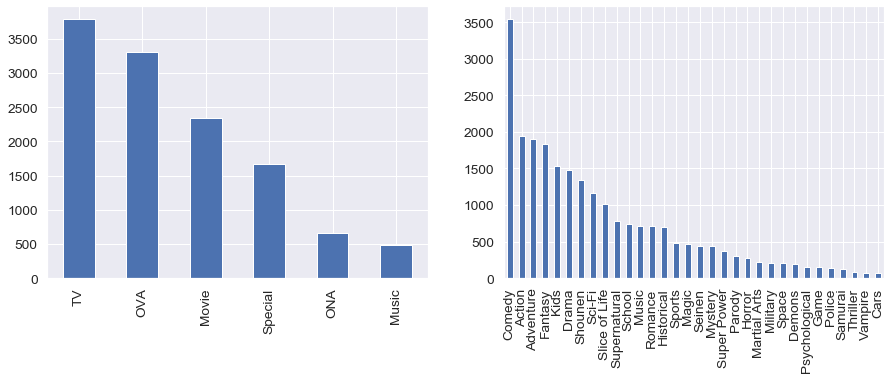

In [7]:
plt.figure(figsize=(15,5))

# Odd categories to be removed
df_filtered = remove_data(df.copy())

plt.subplot(1,2,1)
df['type'].value_counts().plot(kind='bar') # Bar plot of anime type

# Compute occurence of individual categories
list_genre_flat = [clean_string(i).split(', ') for i in list(df_filtered['genre'].copy())]
list_genre_flat = pd.Series([i for s in list_genre_flat for i in s]) # Flatenned list. Each occurence contribute to individual categories
plt.subplot(1,2,2)
list_genre_flat.value_counts().plot(kind='bar') # Bar plot of anime type

Comedy genre is the category which is the most present in this filtered dataset.

## Anime data correlation - TV show

Is there a numerical correlation betweenn user's rating, number of episode and number of members belonging to anime community.
We will focus on TV anime.


In [8]:
df_filtered = df_filtered.loc[df_filtered['type']=='TV']

df_filtered['episodes'] = df_filtered['episodes'].apply(clean_numeric).astype('float') # Replace 0 value with NaN and clean
df_filtered['rating'] = df_filtered['rating'].apply(clean_numeric).astype('float') # Transform to proper numerical data
df_filtered['members'] = df_filtered['members'].apply(clean_numeric).astype('float') # Transform to proper numerical data

df_filtered['episodes'] = df_filtered['episodes'].fillna(df_filtered['episodes'].median())
df_filtered['rating'] = df_filtered['rating'].fillna(df_filtered['rating'].median())
df_filtered['members'] = df_filtered['members'].fillna(df_filtered['members'].median())
# Since we deleted row, it is important to reindex the dataframe, so we don't have missing index
df_filtered = df_filtered.reset_index()
list_index = df_filtered['index'].unique()

df_filtered.head(10)

,index,anime_id,name,genre,type,episodes,rating,members
0,1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665.0
1,2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262.0
2,3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572.0
3,4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266.0
4,5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.0,9.15,93351.0
5,6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148.0,9.13,425855.0
6,9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13.0,9.11,81109.0
7,10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24.0,9.06,456749.0
8,12,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201.0,9.04,336376.0
9,14,28891,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports",TV,25.0,8.93,179342.0


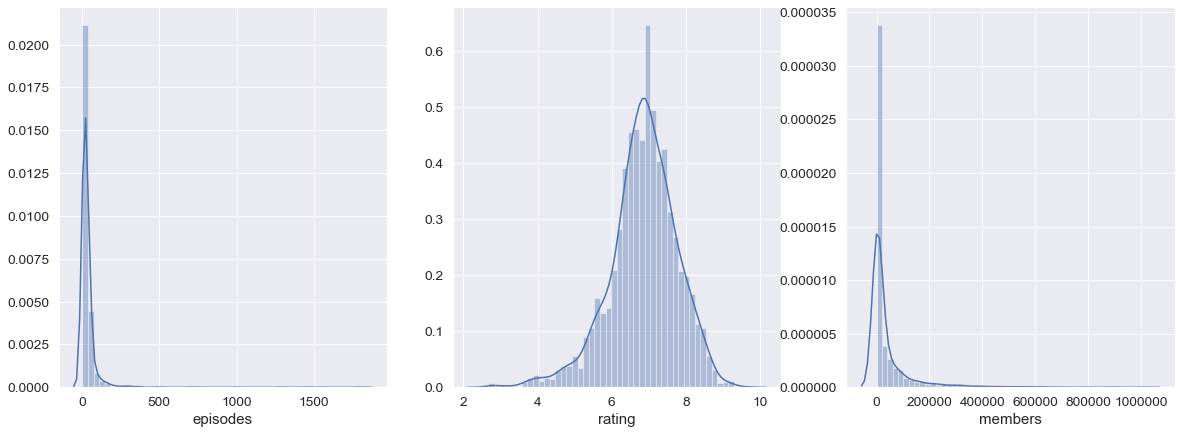

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.distplot(df_filtered['episodes'])
plt.subplot(1,3,2)
sns.distplot(df_filtered['rating'])
plt.subplot(1,3,3)
sns.distplot(df_filtered['members'])

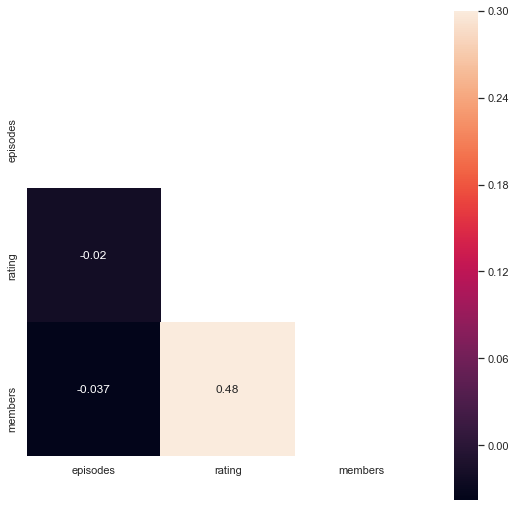

In [10]:
sns.set(font_scale=1)
corr = df_filtered[['episodes','rating','members']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9,9))

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

# Data preparation
Set categorical data and their contribution the type TV (large number of episodes).

In [11]:
def get_index(x):
    return df_filtered[df_filtered['name']==x].index.tolist()[0]
def recommend_me(anime):
    index = get_index(anime)
    print('Here are 10 anime similar to', anime, ' - ', df_filtered.loc[index]['genre'],'\n')
    rec = []
    for j in anime_indices[index][1:]:
        print(df_filtered.loc[j]['name'],' - ', df_filtered.loc[j]['genre'])
        rec.append([df_filtered.loc[j]['anime_id'], df_filtered.loc[j]['name'], df_filtered.loc[j]['genre']])
    rec = pd.DataFrame(rec)
#     rec = rec.transpose()
    rec.columns = ['id', 'name', 'genre']
    return rec

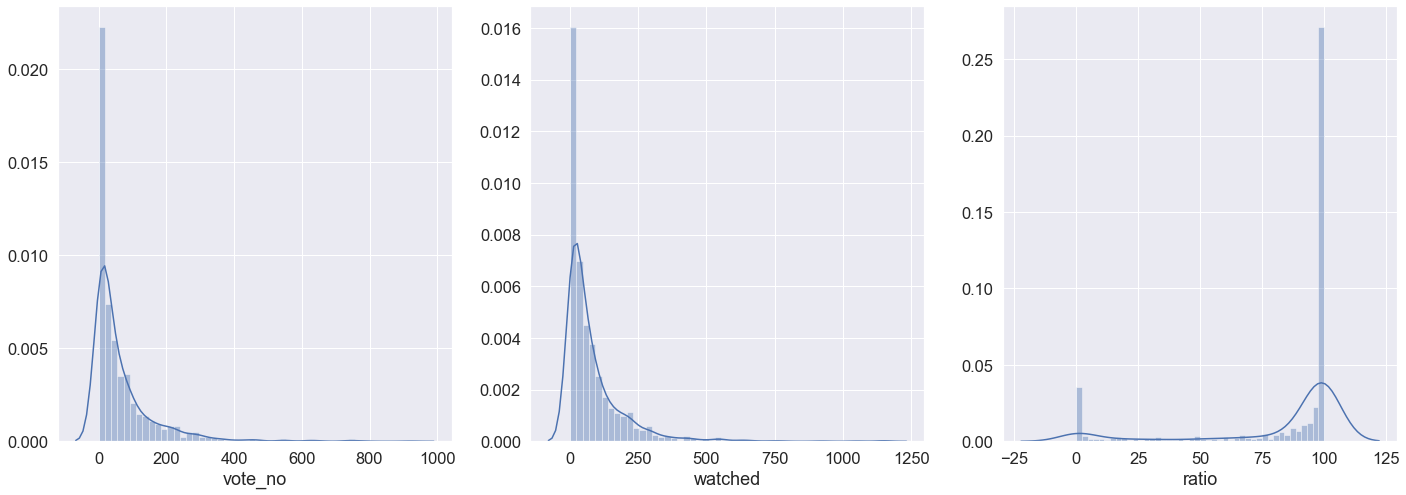

In [13]:
df_rating = pd.read_csv('../data/anime-recommendations-database/rating.csv')
user_no = 1500

# Select data by number of users
df_rating = df_rating.head(df_rating[df_rating['user_id']==df_rating['user_id'].unique()[user_no]].index[-1])

# Removing anime which where removed earlier in the notebook (list of anime). Reset index for avoinding conflict
df_rating = df_rating[~df_rating['anime_id'].isin(list_index)].reset_index(drop=True)

# User rating data investigation
df_count = pd.DataFrame({'user_id': df_rating['user_id'].unique()})
df_count['watched'] = [df_rating[df_rating['user_id']==i].shape[0] for i in df_rating['user_id'].unique()]
df_count['vote_no'] = [len([j for j in list(df_rating[df_rating['user_id']==i]['rating']) if j != -1]) for i in df_rating['user_id'].unique()]
df_count['ratio'] = df_count['vote_no'] / df_count['watched']

# Establish 'like' ranges: 0 to 5 = Dislike; 5 to 7 = Neutral; over 7 = Like
df_count['like'] = [len([j for j in list(df_rating[df_rating['user_id']==i]['rating']) if j !='NaN' and j >= 7]) for i in df_rating['user_id'].unique()]
df_count['neutral'] = [len([j for j in list(df_rating[df_rating['user_id']==i]['rating']) if j !='NaN' and 5 <= j < 7]) for i in df_rating['user_id'].unique()]
df_count['dislike'] = [len([j for j in list(df_rating[df_rating['user_id']==i]['rating']) if j !='NaN' and 0 <= j < 5]) for i in df_rating['user_id'].unique()]
df_count['like_id'] = [[j[1] for j in list(zip(df_rating[df_rating['user_id']==i]['rating'],df_rating[df_rating['user_id']==i]['anime_id'])) if j[0] !='NaN' and j[0] >= 7] for i in df_rating['user_id'].unique()]

sns.set(font_scale=1.5)
plt.figure(figsize=(24,8))
plt.subplot(1,3,1)
sns.distplot(df_count['vote_no'])
plt.subplot(1,3,2)
sns.distplot(df_count['watched'])
plt.subplot(1,3,3)
sns.distplot((100*df_count['ratio']).astype(int))

# Investigate user common base - Collaborative filtering

Check one user like history, check similar user and reccomend based on common viewing history

In [14]:
# Select users with more than 10 votes
df_user = df_count[df_count['vote_no']>=10].reset_index(drop=True)
df_user.head()

,user_id,watched,vote_no,ratio,like,neutral,dislike,like_id
0,3,85,83,0.976471,63,17,3,"[170, 225, 430, 527, 813, 1119, 1121, 1132, 13..."
1,5,378,371,0.981481,86,101,184,"[45, 136, 137, 205, 245, 264, 265, 292, 344, 5..."
2,7,299,299,1.000000,243,54,2,"[31, 59, 65, 136, 170, 225, 245, 249, 407, 435..."
3,8,11,11,1.000000,9,2,0,"[269, 6702, 7593, 8630, 10793, 11241, 11757, 1..."
4,11,75,75,1.000000,61,12,2,"[59, 143, 164, 202, 249, 338, 431, 441, 450, 4..."


In [15]:
# Select user cluster with common like history (at least 10 items common, 10 different items). We investigate user_id = 3
user_no = 5
set_user = np.array(df_user[df_user['user_id'] == user_no]['like_id'].to_numpy()[0])
df_user = df_user[df_user['user_id'] != user_no].reset_index(drop=True)

# Check number of comon items in anime_id list
df_user['common'] = [len([j for j in df_user[df_user['user_id'] == i]['like_id'].to_numpy()[0] if j in set_user]) for i in df_user['user_id'].tolist()]

# Remove items with less than 10 common items
df_user = df_user[df_user['common']>=10].reset_index(drop=True)
df_user['different'] = [len([j for j in df_user[df_user['user_id'] == i]['like_id'].to_numpy()[0] if j not in set_user]) for i in df_user['user_id'].tolist()]
df_user['unseen'] = [[j for j in df_user[df_user['user_id'] == i]['like_id'].to_numpy()[0] if j not in set_user] for i in df_user['user_id'].tolist()]

df_user.sort_values(by='common', ascending=False).head()

,user_id,watched,vote_no,ratio,like,neutral,dislike,like_id,common,different,unseen
203,1176,549,459,0.836066,409,45,5,"[19, 66, 133, 154, 164, 205, 225, 226, 227, 24...",44,365,"[19, 66, 133, 154, 164, 225, 226, 227, 249, 26..."
176,1019,554,551,0.994585,411,138,2,"[15, 24, 154, 170, 240, 245, 282, 384, 807, 85...",42,369,"[15, 24, 154, 170, 240, 282, 384, 807, 856, 85..."
197,1145,1153,780,0.676496,682,96,2,"[33, 66, 80, 81, 83, 85, 164, 182, 194, 205, 2...",38,644,"[33, 66, 80, 81, 83, 85, 164, 182, 194, 225, 2..."
238,1344,1053,739,0.701804,517,209,13,"[7, 15, 31, 33, 71, 75, 81, 83, 164, 165, 169,...",38,479,"[7, 15, 31, 33, 71, 75, 81, 83, 164, 165, 169,..."
259,1456,773,749,0.968952,704,38,7,"[24, 45, 59, 60, 61, 63, 65, 71, 102, 123, 145...",34,670,"[24, 59, 60, 61, 63, 65, 71, 102, 123, 145, 15..."


In [16]:
# User 5 best ratings and corresponding genre
user = df_rating[df_rating['user_id']==user_no]
user = user[user['rating'] != -1].drop(['user_id'],axis=1).reset_index(drop=True)
user = user[['rating','anime_id']]
user['name'] = [str(df_filtered.loc[df_filtered['anime_id']==i]['name'].tolist())[2:-2] for i in user['anime_id']]
user['genre'] = [str(df_filtered.loc[df_filtered['anime_id']==i]['genre'].tolist())[2:-2] for i in user['anime_id']]
# user = user[user['user_id']==user_no]
user.sort_values(by='rating',ascending=False).head(10)

,rating,anime_id,name,genre
20,10,245,Great Teacher Onizuka,"Comedy, Drama, School, Shounen, Slice of Life"
216,10,15335,,
163,9,11577,,
369,9,32182,Mob Psycho 100,"Action, Comedy, Slice of Life, Supernatural"
45,9,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S..."
81,9,3702,,
139,9,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
207,9,14719,JoJo no Kimyou na Bouken (TV),"Action, Adventure, Shounen, Supernatural, Vampire"
358,9,28891,Haikyuu!! Second Season,"Comedy, Drama, School, Shounen, Sports"
71,9,2418,,


In [13]:
# Count number of similar ID in unseen movies
top_common = pd.value_counts(pd.Series([i for s in df_user['unseen'].tolist() for i in s]))
test = pd.DataFrame(top_common)
test['id'] = test.index
test.columns = 'count','id'
test['name'] = [str(df_filtered.loc[df_filtered['anime_id']==i]['name'].tolist())[2:-2] for i in test['id']]
test['genre'] = [str(df_filtered.loc[df_filtered['anime_id']==i]['genre'].tolist())[2:-2] for i in test['id']]
test = test.reset_index(drop=True)
test.head()

,count,id,name,genre
0,218,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power"
1,194,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
2,194,19815,,
3,190,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ..."
4,180,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."


# Item based recommendation

In [15]:
genre_filtered = df_filtered['genre'].str.get_dummies(sep=',')
X = pd.concat([genre_filtered, df_filtered['rating'], df_filtered['members']],axis=1)
scaled = MaxAbsScaler()
X = scaled.fit_transform(X)
reg = NearestNeighbors(n_neighbors=11, algorithm='ball_tree').fit(X)
anime_indices = reg.kneighbors(X)[1] # picks off the array for anime indices
rec = recommend_me('Shingeki no Kyojin')
rec.head(10)

Here are 10 anime similar to Shingeki no Kyojin  -  Action, Drama, Fantasy, Shounen, Super Power 

Shingeki no Kyojin Season 2  -  Action, Drama, Fantasy, Shounen, Super Power
One Piece  -  Action, Adventure, Comedy, Drama, Fantasy, Shounen, Super Power
Utawarerumono: Itsuwari no Kamen  -  Action, Drama, Fantasy
Big Order (TV)  -  Action, Shounen, Super Power
Juushin Enbu: Hero Tales  -  Action, Fantasy, Shounen
Weiß Kreuz  -  Action, Drama, Shounen
Spheres  -  Action, Fantasy, Super Power
X-Men  -  Action, Drama, Super Power
Otoko Ippiki Gaki Daishou  -  Action, Drama, Shounen
Weiß Kreuz Glühen  -  Action, Drama, Shounen


,id,name,genre
0,25777,Shingeki no Kyojin Season 2,"Action, Drama, Fantasy, Shounen, Super Power"
1,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,30901,Utawarerumono: Itsuwari no Kamen,"Action, Drama, Fantasy"
3,31904,Big Order (TV),"Action, Shounen, Super Power"
4,2772,Juushin Enbu: Hero Tales,"Action, Fantasy, Shounen"
5,447,Weiß Kreuz,"Action, Drama, Shounen"
6,18447,Spheres,"Action, Fantasy, Super Power"
7,6919,X-Men,"Action, Drama, Super Power"
8,17467,Otoko Ippiki Gaki Daishou,"Action, Drama, Shounen"
9,446,Weiß Kreuz Glühen,"Action, Drama, Shounen"


In [ ]:
# Add user similarity section - it also include dislike anime